goal is to use spikes from left and right as predictors, for teh smooth spiked train of the attention neuron. can then see how wel left vs right inputs explain the attention neuron and if this changes depending on the attention condition.  

will take inputs x: (trials x time, 160)
y: activity of a single attention neuron (trials x time, )

first will convolve spiking data

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import time
import gc
import copy

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
def smooth_with_gaussian(data, sigma=2):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

#file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]
file_numbers = [1]
structure = {f'dataset_{file_number}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for file_number in file_numbers}


def preprocess(data):
    #data shape: (trials, time, neurons)
    trials, time, num_neurons = data.shape
    z = np.zeros_like(data)

    for neuron in range(num_neurons):
        for t in range(time):
            vals = data[:, t, neuron]  #this is all the data for given neuron at given time point
            std = np.std(vals)
            if std > 1e-6:
                z[:, t, neuron] = (vals - np.mean(vals)) / std    #zscore if there is a stdev
            else:
                z[:, t, neuron] = np.median(vals)   #returnt the median value otherwise  (median rather than mean in case of large variability in a singel point)

    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z


def get_data(file_number):
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    data = pickle.load(open(file_path, 'rb'))
  
    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted ==0)[0]
  

    left_input_SP = data['SP'][0][0][relevant]
    right_input_SP = data['SP'][0][1][relevant]
    attention_SP = data['SP'][0][2][relevant]
    #shapes 1057, 500, 160/80)

    #add in here at some point left != right and see if it makes a difference
    left_indices_agg = np.where((omitted ==0) & (attend_01 == 0))[0]  #indices of agg where left
    _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices = True)   #indices for relevant processed data where attention left
    right_indices_agg = np.where((omitted ==0) & (attend_01 == 1))[0]
    _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices = True)

    print(left_indices.shape, right_indices.shape)
    #shapes (500 trials ish, 500, 160/80)
    num_trials, num_samples, num_neurons = left_input_SP.shape
    num_neurons_attention = 80

    sigma = 2
    left_sm = smooth_with_gaussian(left_input_SP, sigma=sigma) 
    right_sm = smooth_with_gaussian(right_input_SP, sigma=sigma) 
    att_sm = smooth_with_gaussian(attention_SP, sigma=sigma) 

    
    for j in range(0, num_trials):
        for i in range(0, num_neurons):
            count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
            if count_left > 0:
                left_sm[j, :, i] /= count_left
            count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
            if count_right > 0:
                right_sm[j, :, i] /= count_right


        for i in range(0, num_neurons_attention):
            count_attention = np.count_nonzero(attention_SP[j, :, i] == 1)
            if count_attention > 0:
                att_sm[j, :, i] /= count_attention
  

   
    

    #preprocess here now that we have traces of all of the relavant trials
    left_input_SP = preprocess(left_input_SP)[:, 100:350, :]
    right_input_SP = preprocess(right_input_SP)[:, 100:350, :]
    attention_SP = preprocess(attention_SP)[:, 100:350, :]

    plt.plot(attention_SP[0, :, 0])
    plt.show()

    return left_input_SP, right_input_SP, attention_SP, left_indices, right_indices

   


(495,) (562,)


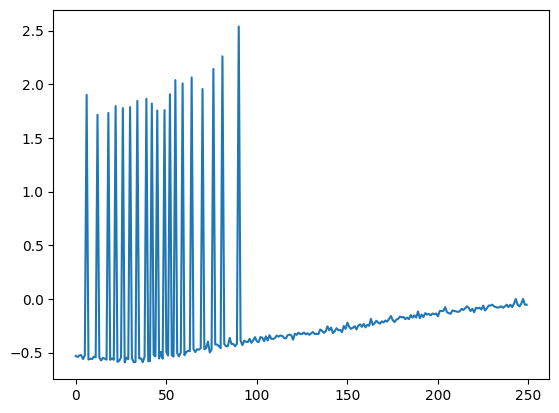

In [13]:
left_input_SP, right_input_SP, attention_SP, left_indices, right_indices = get_data(1)


(495, 250, 320)
(123750, 320) (123750,)
R^2 for attention neuron 1 on attention-left trials: 0.0498


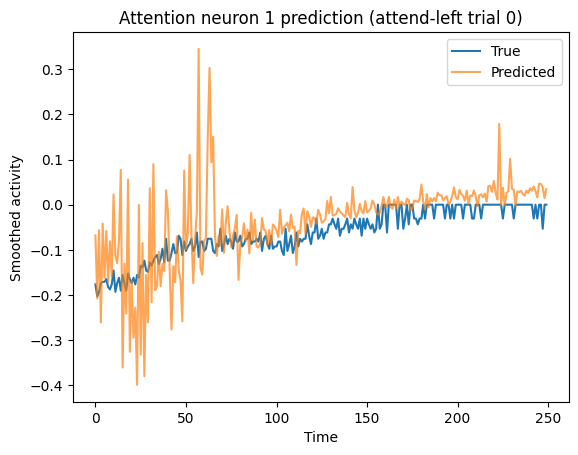

In [11]:
target_neuron = 1

X_left = np.concatenate([left_input_SP[left_indices], right_input_SP[left_indices]], axis=2)  
print(X_left.shape)
y_left = attention_SP[left_indices, :, target_neuron]

num_trials, T, num_inputs = X_left.shape
X = X_left.reshape(num_trials * T, num_inputs)  #shape (n_trials X 250, 320)
y = y_left.reshape(num_trials * T)              #shape (n_trials X 250)

print(X.shape, y.shape)
#the model will learn one set of weights to predict the neurons signal across all trials
#doesnt train trial specific weights
#it tells us how the 320 input neurons drive the actibity of the attention neuron across all trials
#


model = Ridge(alpha = 1.0)
model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
print(f"R^2 for attention neuron {target_neuron} on attention-left trials: {r2:.4f}")

# Optional: plot predicted vs true for a single trial
trial_idx = 0
plt.plot(y_left[trial_idx], label='True')
plt.plot(y_pred.reshape(num_trials, T)[trial_idx], label='Predicted', alpha=0.7)
plt.title(f'Attention neuron {target_neuron} prediction (attend-left trial {trial_idx})')
plt.xlabel('Time')
plt.ylabel('Smoothed activity')
plt.legend()
plt.show()


will look here at training trial by trial 

In [32]:
alph = 1.0
T = attention_SP.shape[1]
num_att_neurons = attention_SP.shape[2]

#trial r2 for each neuron
r2_left_attleft_trials = [[] for _ in range(num_att_neurons)]
r2_right_attleft_trials = [[] for _ in range(num_att_neurons)] #can get a list in each [] of all neurons (for each trial)
r2_left_attright_trials = [[] for _ in range(num_att_neurons)]
r2_right_attright_trials = [[] for _ in range(num_att_neurons)]


# === Attend-left trials ===
for trial in range(len(left_indices)):
    idx = left_indices[trial]  #this gets the index of the trial in the relevant data
    
    #then for that trial, get the data for each neuron in this trial
    X_l = left_input_SP[idx] 
    X_r = right_input_SP[idx]
    
    for n in range(num_att_neurons): #look at each neuron
        y = attention_SP[idx, :, n]  #attention signal for this neuron
        
        #left 
        model_l = Ridge(alpha=alph).fit(X_l, y)
        y_pred_l = model_l.predict(X_l)  #this gives the prediction signal for the neuron / trial
        r2_l = r2_score(y, y_pred_l)
        r2_left_attleft_trials[n].append(r2_l)  #
        
        #right
        model_r = Ridge(alpha=alph).fit(X_r, y)
        y_pred_r = model_r.predict(X_r)
        r2_r = r2_score(y, y_pred_r)
        r2_right_attleft_trials[n].append(r2_r)

for trial in range(len(right_indices)):
    idx = right_indices[trial]

    X_l = left_input_SP[idx]
    X_r = right_input_SP[idx]

    for n in range(num_att_neurons):
        y = attention_SP[idx, :, n]

        model_l = Ridge(alpha=alph).fit(X_l, y)
        y_pred_l = model_l.predict(X_l)
        r2_l = r2_score(y, y_pred_l)
        r2_left_attright_trials[n].append(r2_l)

        model_r = Ridge(alpha=alph).fit(X_r, y)
        y_pred_r = model_r.predict(X_r)
        r2_r = r2_score(y, y_pred_r)
        r2_right_attright_trials[n].append(r2_r)


(80, 495)
(495, 80)
(1057, 80)


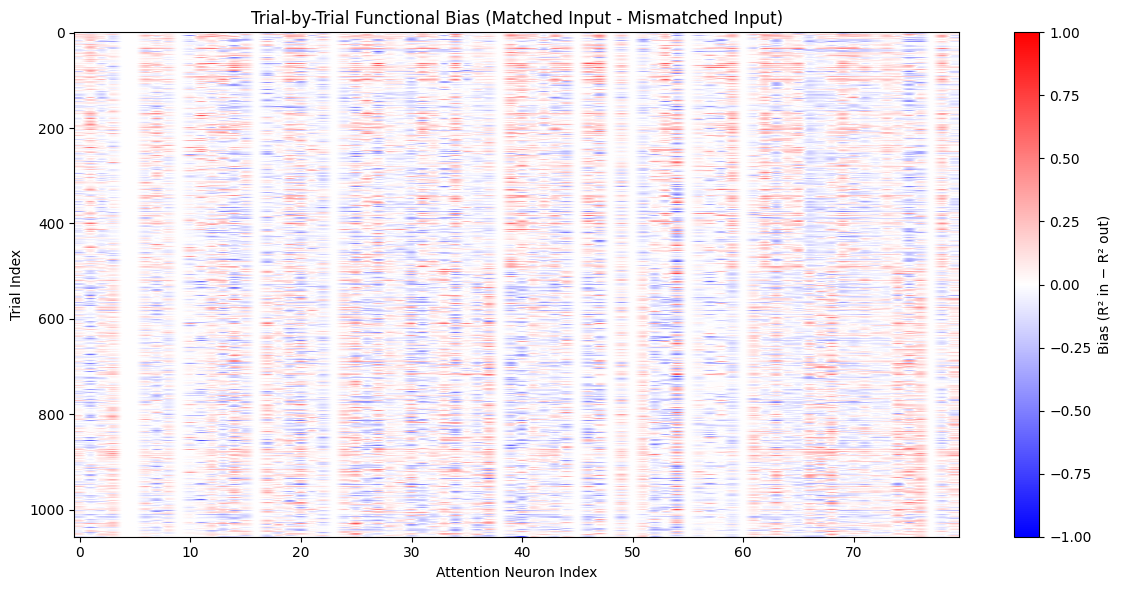

In [ ]:
r2_LL = np.array(r2_left_attleft_trials)     
r2_LR = np.array(r2_right_attleft_trials)
r2_RL = np.array(r2_left_attright_trials)
r2_RR = np.array(r2_right_attright_trials)

print(r2_LL.shape)

r2_LL = r2_LL.T
r2_LR = r2_LR.T
r2_RL = r2_RL.T
r2_RR = r2_RR.T

print(r2_LL.shape)

bias_attleft_trials = r2_LL - r2_LR  
bias_attright_trials = r2_RR - r2_RL  

bias_matrix = np.vstack([bias_attleft_trials, bias_attright_trials])
print(bias_matrix.shape)

plt.figure(figsize=(12, 6))
plt.imshow(bias_matrix, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(label='Bias (R² in − R² out)')
plt.xlabel('Attention Neuron Index')
plt.ylabel('Trial Index')
plt.title('Trial-by-Trial Functional Bias (Matched Input - Mismatched Input)')
plt.tight_layout()
plt.show()



[ 0  1  2  3  6  8 11 12 17 18 19 21 24 25 28 29 32 33 34 37 39 41 47 49
 51 53 59 61 62 64 65 68 69 73 74 76 78 79]


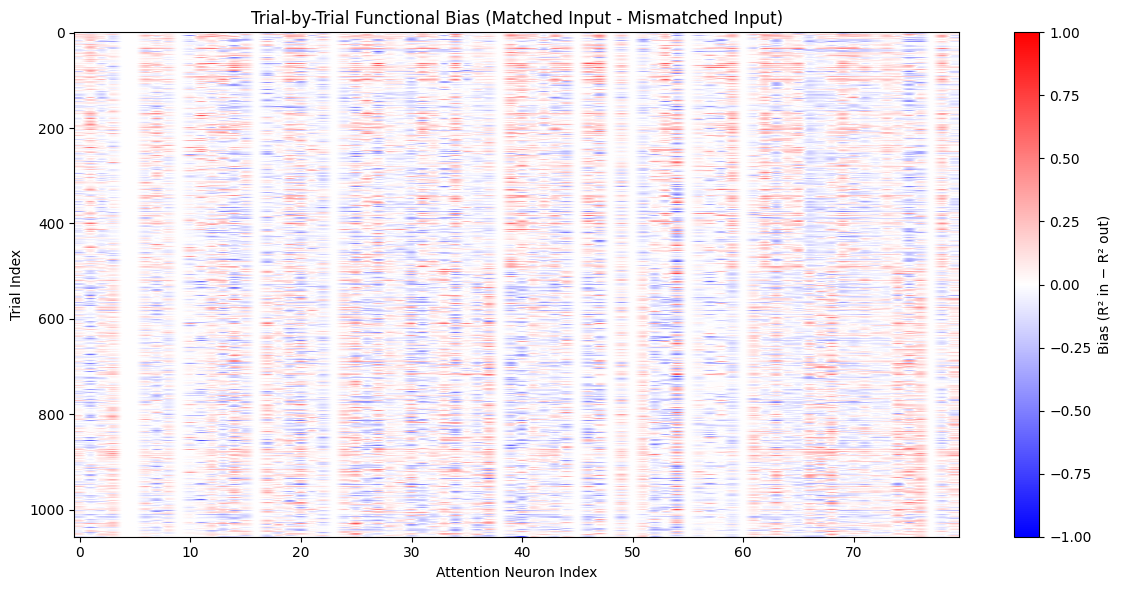

In [53]:
mean_bias_per_neuron = np.mean(bias_matrix, axis=0)
mean_thresh = 0.0

mask = (mean_bias_per_neuron > mean_thresh) 
indices = np.where(mask)[0]
print(indices)

filtered = bias_matrix[:, mask]

plt.figure(figsize=(12, 6))
plt.imshow(bias_matrix, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(label='Bias (R² in − R² out)')
plt.xlabel('Attention Neuron Index')
plt.ylabel('Trial Index')
plt.title('Trial-by-Trial Functional Bias (Matched Input - Mismatched Input)')
plt.tight_layout()
plt.show()


(123750,)


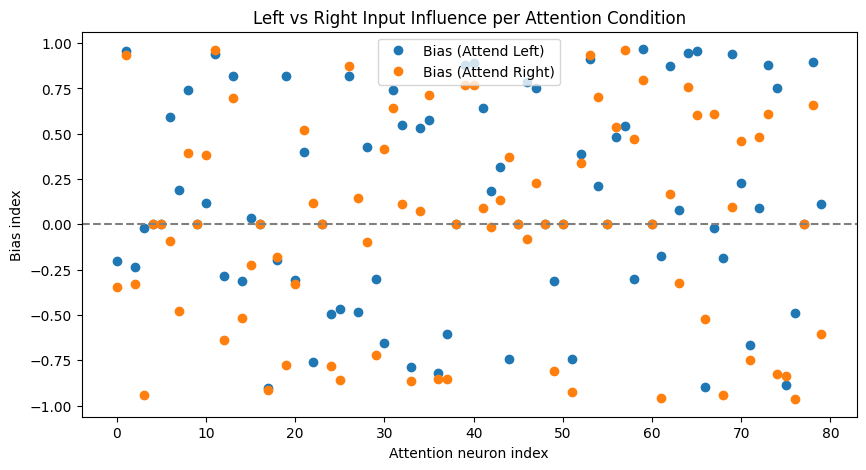

In [40]:
epsilon = 1e-6
alph = 1.0

r2_left_attleft = []
r2_right_attleft = []
r2_left_attright = []
r2_right_attright = []

num_att_neurons = attention_SP.shape[2]
T = attention_SP.shape[1]

for n in range(num_att_neurons):
    #attend left 
    y = attention_SP[left_indices, :, n].reshape(-1)
    if n == 1:
        print(y.shape)   #so take the nth neuron and for vector of 500*250
    
  #till then take the left and right inputs as
    X_l = left_input_SP[left_indices].reshape(len(left_indices) * T, -1)  
    model_l = Ridge(alpha=alph).fit(X_l, y)
    y_pred_l = model_l.predict(X_l)
    r2_l = r2_score(y, y_pred_l)
    r2_left_attleft.append(r2_l)

    
    X_r = right_input_SP[left_indices].reshape(len(left_indices) * T, -1)
    model_r = Ridge(alpha=alph).fit(X_r, y)
    y_pred_r = model_r.predict(X_r)
    r2_r = r2_score(y, y_pred_r)
    r2_right_attleft.append(r2_r)

    #attend  right 
    y = attention_SP[right_indices, :, n].reshape(-1)

    X_l = left_input_SP[right_indices].reshape(len(right_indices) * T, -1)
    model_l = Ridge(alpha=alph).fit(X_l, y)
    y_pred_l = model_l.predict(X_l)
    r2_l = r2_score(y, y_pred_l)
    r2_left_attright.append(r2_l)

    X_r = right_input_SP[right_indices].reshape(len(right_indices) * T, -1)
    model_r = Ridge(alpha=alph).fit(X_r, y)
    y_pred_r = model_r.predict(X_r)
    r2_r = r2_score(y, y_pred_r)
    r2_right_attright.append(r2_r)

#define bias coefficients, that will be 0 if r2 is the same for both
# and will be positive if left is more predictive when attending left
bias_attleft = (np.array(r2_left_attleft) - np.array(r2_right_attleft)) / \
               (np.array(r2_left_attleft) + np.array(r2_right_attleft) + epsilon)

#define this one to be negative if the right input is more influential when attending right, 
#and 0 if they are both the same. 
bias_attright = (np.array(r2_left_attright) - np.array(r2_right_attright)) / \
                (np.array(r2_left_attright) + np.array(r2_right_attright) + epsilon)


#not sure of the sign here?



plt.figure(figsize=(10, 5))
plt.plot(bias_attleft, 'o', label='Bias (Attend Left)')
plt.plot(bias_attright, 'o', label='Bias (Attend Right)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Attention neuron index')
plt.ylabel('Bias index')
plt.legend()
plt.title('Left vs Right Input Influence per Attention Condition')
plt.show()



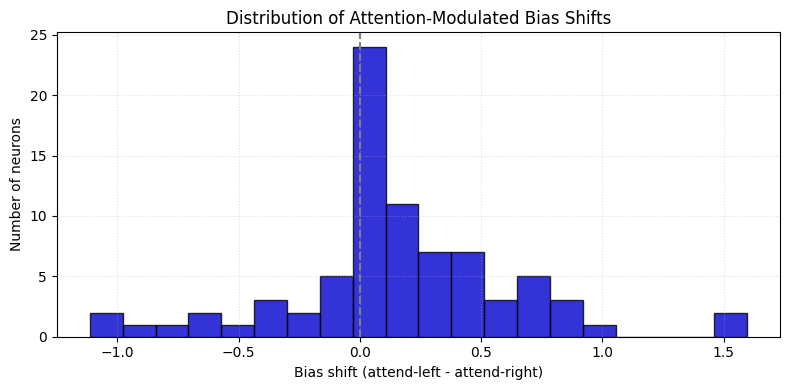

In [41]:
import matplotlib.pyplot as plt
import numpy as np


delta_bias = np.array(bias_attleft) - np.array(bias_attright)
#sifference is left left + right right - leftright - rightleft
#want therefore to see a positive skew to indicate attentional influence

plt.figure(figsize=(8, 4))
plt.hist(delta_bias, bins=20, color='mediumblue', alpha=0.8, edgecolor='k')
plt.axvline(0, linestyle='--', color='gray')
plt.xlabel('Bias shift (attend-left - attend-right)')
plt.ylabel('Number of neurons')
plt.title('Distribution of Attention-Modulated Bias Shifts')
plt.grid(True, linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()


In [42]:
mean_shift = np.mean(delta_bias)
std_shift = np.std(delta_bias)

from scipy.stats import ttest_1samp
t_stat, p_val = ttest_1samp(delta_bias, 0)

print(f"Mean bias shift: {mean_shift:.3f} ± {std_shift:.3f}")
print(f"t = {t_stat:.2f}, p = {p_val:.4f}")


Mean bias shift: 0.144 ± 0.467
t = 2.74, p = 0.0075


In [43]:
import numpy as np

# Already computed earlier:
# bias_attleft, bias_attright

delta_bias = np.array(bias_attleft) - np.array(bias_attright)
modulation_strength = np.abs(delta_bias)
sorted_indices = np.argsort(modulation_strength)[::-1]  # descending order

# Top 10 most attention-modulated neurons
top_neurons = sorted_indices[:10]
print("Top modulated neurons:", top_neurons)


Top modulated neurons: [19 74 44 30  3 22 46 69 61 58]


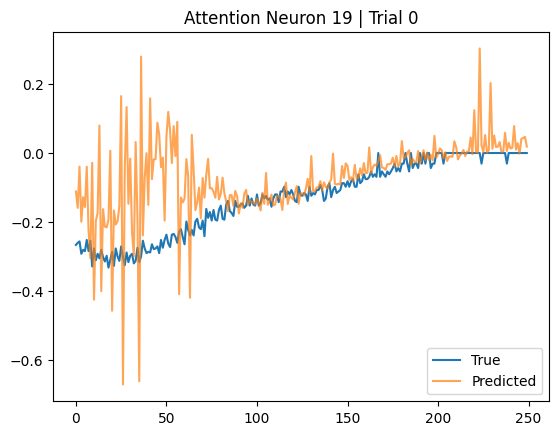

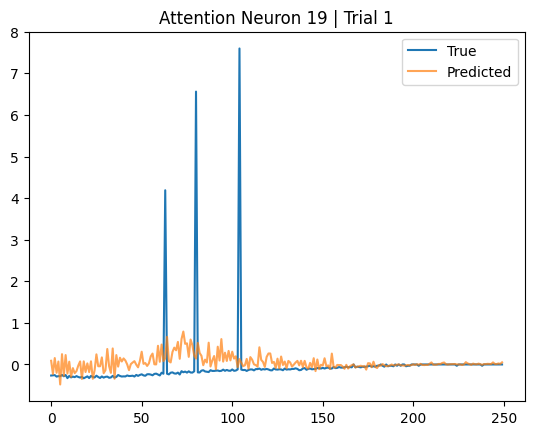

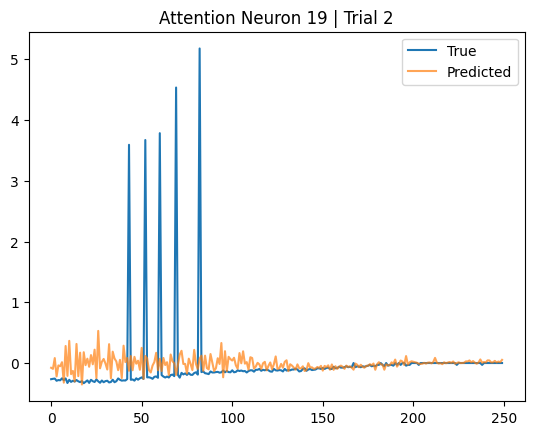

In [ ]:
import matplotlib.pyplot as plt

target_n = top_neurons[0]

T = attention_SP.shape[1]
num_trials = len(left_indices)

X_left = np.concatenate((left_input_SP[left_indices], right_input_SP[left_indices]), axis=2)
X = X_left.reshape(num_trials * T, -1)
y_true = attention_SP[left_indices, :, target_n].reshape(num_trials * T)

from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)
model.fit(X, y_true)
y_pred = model.predict(X).reshape(num_trials, T)

# Plot a few trials
for trial in [0, 1, 2]:
    plt.figure()
    plt.plot(attention_SP[left_indices[trial], :, target_n], label='True')
    plt.plot(y_pred[trial], label='Predicted', alpha=0.7)
    plt.title(f"Attention Neuron {target_n} | Trial {trial}")
    plt.legend()
    plt.show()


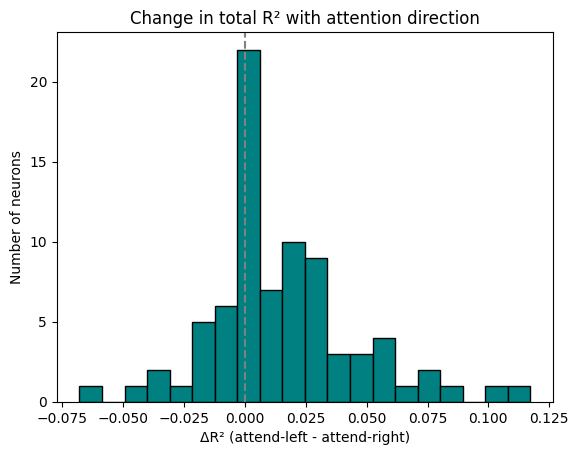

In [44]:
r2_in = np.array(r2_left_attleft) + np.array(r2_right_attright)
r2_out = np.array(r2_left_attright) + np.array(r2_right_attleft)

r2_diff = r2_in - r2_out

plt.hist(r2_diff, bins=20, color='teal', edgecolor='k')
plt.axvline(0, linestyle='--', color='gray')
plt.xlabel('ΔR² (attend-left - attend-right)')
plt.ylabel('Number of neurons')
plt.title('Change in total R² with attention direction')
plt.show()


C:\Users\joshu\AppData\Local\Temp\ipykernel_16280\509308688.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


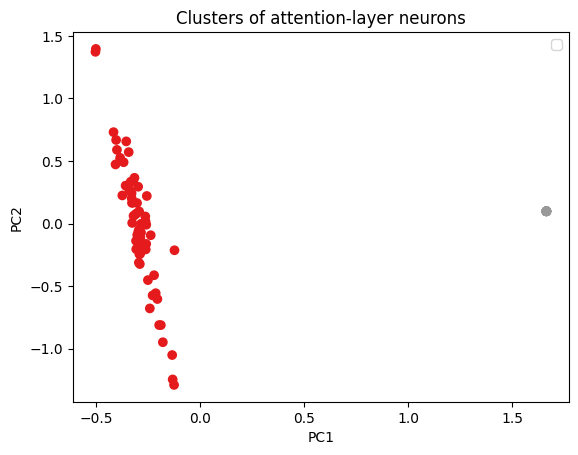

In [50]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

features = np.stack([
    r2_left_attleft,
    r2_right_attleft,
    r2_left_attright,
    r2_right_attright,
    delta_bias
], axis=1)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
proj = pca.fit_transform(features)

kmeans = KMeans(n_clusters=2, random_state=42).fit(proj)
labels = kmeans.labels_

plt.figure()
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='Set1')
plt.title('Clusters of attention-layer neurons')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


In [ ]:
outlier_idx = np.where(proj[:, 0] > 1.0)[0]
print("Outlier neurons:", outlier_idx)


Outlier neurons: [ 4  5  9 16 23 38 45 48 50 55 60 77]
Their feature values:
 [[1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]]
